In [91]:
import os
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
run = 'random-5-imagenette-woof'
dataset = 'ImagenetteWoof'
first_split = pd.concat([pd.read_csv(f'predictions/{dataset}/{run}/first-split/{f}') for f in os.listdir(f'predictions/{dataset}/{run}/first-split')])
second_split = pd.concat([pd.read_csv(f'predictions/{dataset}/{run}/second-split/{f}') for f in os.listdir(f'predictions/{dataset}/{run}/second-split')])
first_split

,image_id,stage,epoch,label,prediction,loss,conf
0,1336,first-split,36,1.0,1.0,0.045430,0.928872
1,5274,first-split,36,5.0,5.0,0.039364,0.938004
2,3434,first-split,36,4.0,4.0,0.038229,0.939366
3,4188,first-split,36,4.0,4.0,0.009723,0.984216
4,3842,first-split,36,4.0,4.0,0.081760,0.874786
...,...,...,...,...,...,...,...
4508,7872,first-split,72,8.0,8.0,0.013408,0.978934
4509,972,first-split,72,1.0,1.0,0.013661,0.978057
4510,6318,first-split,72,7.0,7.0,0.005269,0.991605
4511,5184,first-split,72,5.0,5.0,0.001682,0.997268


## First Split Learning Time

aka the first epoch at which example x is classified correctly for the rest of (stage 1) training

In [93]:
def get_fslt(df):
    df = df.sort_values('epoch', ascending=False)
    incorrect = df[df['prediction'] != df['label']]
    if len(incorrect) == 0:
        return 0
    else:
        return incorrect.iloc[0]['epoch'] + 1 # +1 because we want the first epoch where the model was correct

fslt = first_split.groupby('image_id', as_index=False).apply(get_fslt)
fslt.columns = ['image_id', 'fslt']

## Second Split Forgetting Time

aka the first epoch where example x is never classified correctly

In [94]:
def get_ssft(df):
    df = df.sort_values('epoch', ascending=False)
    correct = df[df['prediction'] == df['label']]
    if len(correct) == 0:
        return 0
    else:
        return correct.iloc[0]['epoch'] + 1 # +1 because we want the first epoch where the model was incorrect

ssft = second_split.groupby('image_id', as_index=False).apply(get_ssft)
ssft.columns = ['image_id', 'ssft']

## Baseline Methods for Example Hardness

**Number of forgetting events** = number of times the model flipped the prediction on example x

**Cumulative Learning Accuracy** = number of epochs the model correctly classified example x

**Cumulative Learning Confidence** = cumulative softmax confidence of example x wrt correct class 

In [95]:
def calc_num_forgetting(df):
    last_pred = -1
    num_forgetting = 0
    for i, row in df.iterrows():
        if i == 0:
            last_pred = row['prediction']
        elif row['prediction'] != last_pred:
            num_forgetting += 1
            last_pred = row['prediction']
    return num_forgetting

def calc_cumulative_learning(df):
    return len(df[df['prediction'] == df['label']])

def calc_cumulative_confidence(df):
    return df['conf'].sum()

def calc_cumulative_loss(df):
    return df['loss'].sum()

In [96]:
num_forgetting = first_split.groupby('image_id', as_index=False).apply(calc_num_forgetting)
num_forgetting.columns = ['image_id', 'num_forgetting']

cumulative_learning = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_learning)
cumulative_learning.columns = ['image_id', 'cumulative_learning']

cumulative_confidence = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_confidence)
cumulative_confidence.columns = ['image_id', 'cumulative_confidence']

cumulative_loss = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_loss)
cumulative_loss.columns = ['image_id', 'cumulative_loss']

In [97]:
results = pd.concat([fslt, ssft, num_forgetting, cumulative_learning, cumulative_confidence, cumulative_loss], axis=1)
results = results.loc[:,~results.columns.duplicated()].copy()
results

,image_id,fslt,ssft,num_forgetting,cumulative_learning,cumulative_confidence,cumulative_loss
0,0,0,100,1,100,94.334015,5.255971
1,2,0,100,1,100,95.493346,4.005067
2,4,1,100,3,99,94.903996,4.953491
3,6,0,100,1,100,94.824548,4.842979
4,8,0,100,1,100,90.710936,7.520230
...,...,...,...,...,...,...,...
4508,9016,1,100,3,99,92.662958,6.628100
4509,9018,0,100,1,100,94.993849,4.883207
4510,9020,1,100,3,99,94.358444,5.724962
4511,9022,1,100,3,99,80.892566,16.159642


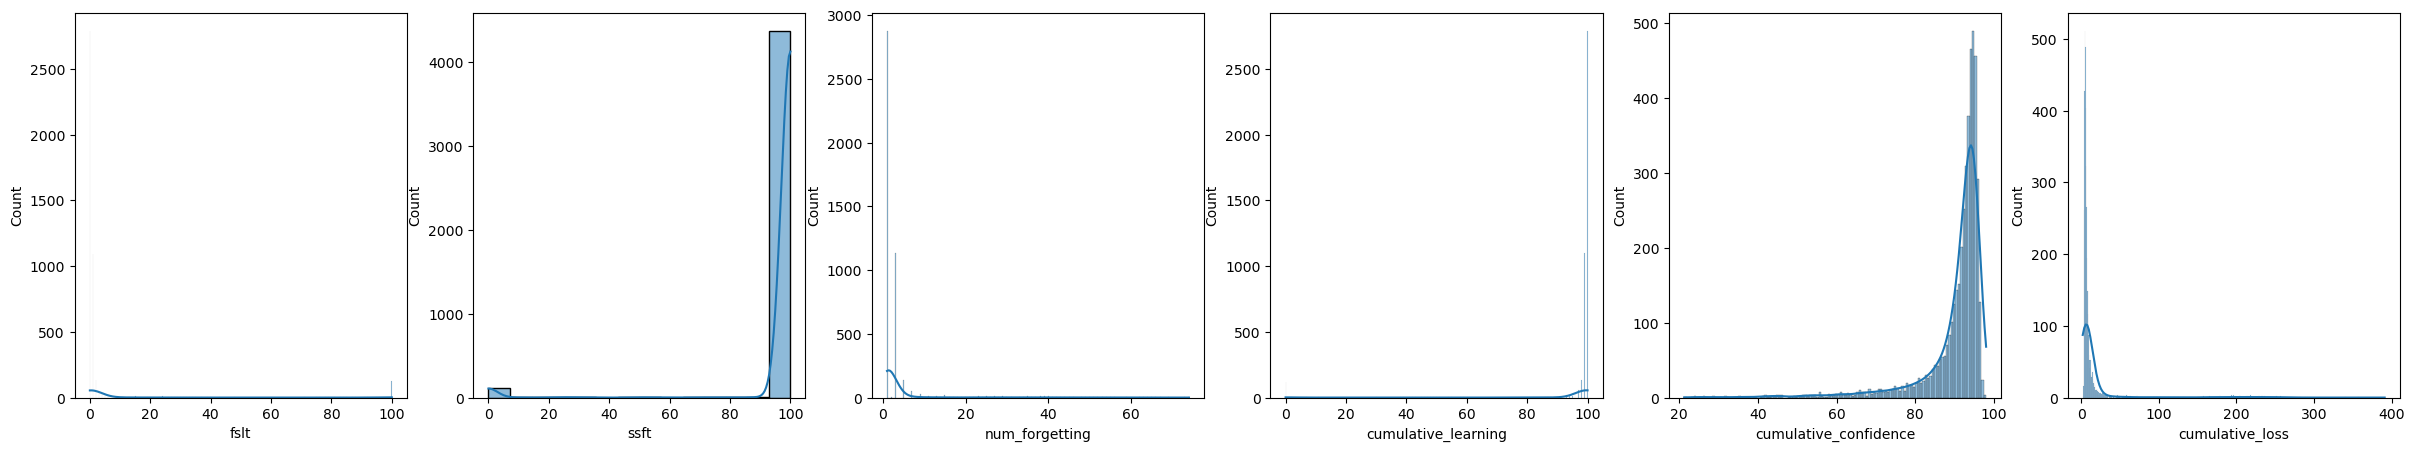

In [98]:
fig, axs = plt.subplots(1, len(results.columns)-1, figsize=(30, 5))

for c in results.columns[1:]:
    sns.histplot(data=results, x=c, kde=True, ax=axs[results.columns.get_loc(c)-1])

## Visualize Hard Examples

<img src="main_fig.png" alt="drawing" width="400"/>

In [99]:
from omegaconf import OmegaConf
args = OmegaConf.load('configs/imagenettewoof/random.yaml')
torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [100]:
method = 'fslt'

from datasets.get_dataset import get_dataset
from datasets.base import BaseDataset

dataset = BaseDataset(get_dataset(args.data.dataset, cfg=args, split='train'), args)

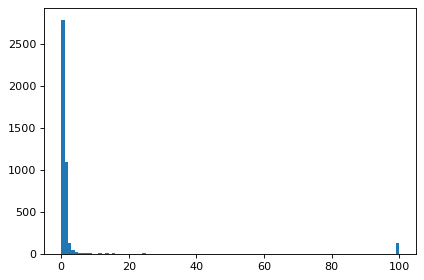

In [75]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(results[method], bins=np.sort(results[method].unique()))
plt.show()

#### Check Which Examples have a Large FSLT

In [101]:
potentially_mislabled_ex = results[(results['fslt'] == 100) & (results['ssft'] < 10)]['image_id'].to_list()
# potentially_mislabled_ex['image_id'].to_list()
# get first split labels
noisy_labels, clean_labels = np.array(dataset.labels)[results['image_id']], np.array(dataset.clean_labels)[results['image_id']]
mislabeled_gt = [results['image_id'][i] for i in range(len(noisy_labels)) if noisy_labels[i] != clean_labels[i]]
len(mislabeled_gt) / len(dataset)

0.023490304709141274

In [102]:
len(potentially_mislabled_ex), len(mislabeled_gt)

(114, 212)

In [103]:
len([p for p in potentially_mislabled_ex if p in mislabeled_gt])/len(potentially_mislabled_ex)

0.9912280701754386

In [104]:
results[results['ssft'] > 5]

,image_id,fslt,ssft,num_forgetting,cumulative_learning,cumulative_confidence,cumulative_loss
0,0,0,100,1,100,94.334015,5.255971
1,2,0,100,1,100,95.493346,4.005067
2,4,1,100,3,99,94.903996,4.953491
3,6,0,100,1,100,94.824548,4.842979
4,8,0,100,1,100,90.710936,7.520230
...,...,...,...,...,...,...,...
4508,9016,1,100,3,99,92.662958,6.628100
4509,9018,0,100,1,100,94.993849,4.883207
4510,9020,1,100,3,99,94.358444,5.724962
4511,9022,1,100,3,99,80.892566,16.159642


In [89]:
dataset.clean_labels[18], dataset.labels[18]

(0, 2)

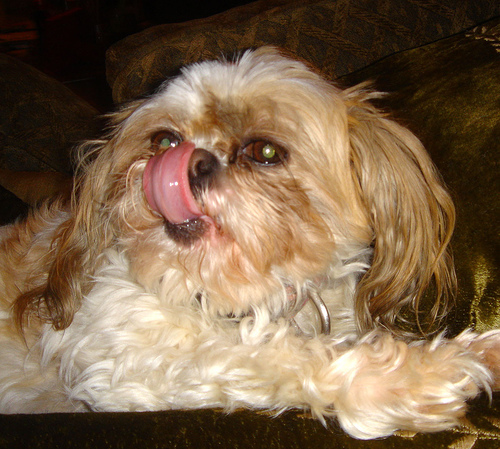

In [86]:
dataset.dataset.vis_example(18)